# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [14]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import AutoTokenizer

# Define Paths

In [3]:
IMAGES_DIR = '/content/drive/MyDrive/nn dataset/images/images_normalized'
REPORTS_FILE = '/content/drive/MyDrive/nn dataset/indiana_reports.csv'
PROJECTIONS_FILE = '/content/drive/MyDrive/nn dataset/indiana_projections.csv'

# Load CSV Files

In [4]:
reports_df = pd.read_csv(REPORTS_FILE)
projections_df = pd.read_csv(PROJECTIONS_FILE)

print("Reports:", reports_df.shape)
print("Projections:", projections_df.shape)

Reports: (3851, 8)
Projections: (7466, 3)


In [5]:
reports_df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [6]:
projections_df.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


# Merge Reports + Images

In [7]:
# Merge reports and projections
data = projections_df.merge(reports_df, on='uid', how='inner')

print("After merge:", len(data))

# Keep FRONTAL images only (Indiana dataset uses 'Frontal')
data = data[data['projection'] == 'Frontal']

print("After frontal filter:", len(data))


After merge: 7466
After frontal filter: 3818


In [8]:
# Combine text
data['combined_text'] = (
    data['findings'].fillna('') + " " +
    data['impression'].fillna('')
)

# Binary label (normal vs abnormal)
data['label'] = data['combined_text'].apply(
    lambda x: 0 if 'normal' in x.lower() else 1
)

print("Final dataset size:", len(data))

Final dataset size: 3818


In [9]:
data.head()

,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression,combined_text,label
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,The cardiac silhouette and mediastinum size ar...,0
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,Borderline cardiomegaly. Midline sternotomy XX...,1
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p...","No displaced rib fractures, pneumothorax, or ...",0
6,4,4_IM-2050-1001.dcm.png,Frontal,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,There are diffuse bilateral interstitial and a...,0
8,5,5_IM-2117-1003002.dcm.png,Frontal,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.,The cardiomediastinal silhouette and pulmonary...,0


# EDA

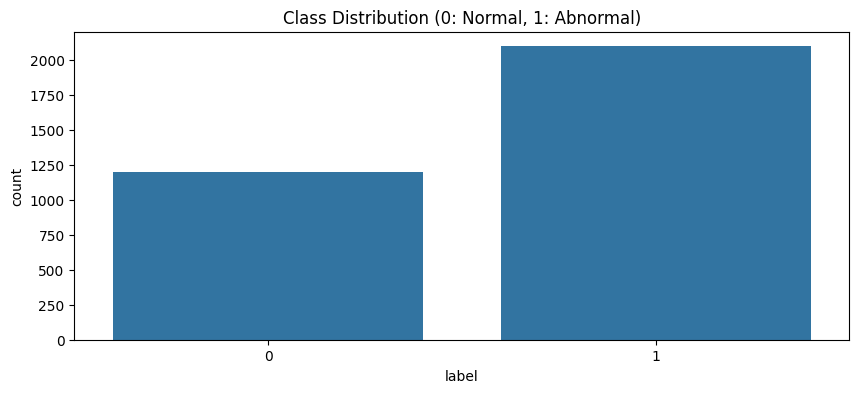

In [15]:
def prepare_and_eda(reports_path, projections_path):
    reports = pd.read_csv(reports_path)
    projections = pd.read_csv(projections_path)
    df = pd.merge(projections, reports, on='uid')
    df = df[df['projection'] == 'Frontal'].reset_index(drop=True)

    # Cleaning & Labeling
    df.dropna(subset=['findings', 'impression', 'filename'], inplace=True)
    df['report_text'] = df['findings'] + " " + df['impression']

    # Logic to create binary labels: 0 for 'normal', 1 for abnormal
    df['label'] = df['Problems'].apply(lambda x: 0 if 'normal' in str(x).lower() else 1)

    # EDA: Visualize Class Distribution
    plt.figure(figsize=(10, 4))
    sns.countplot(x='label', data=df)
    plt.title("Class Distribution (0: Normal, 1: Abnormal)")
    plt.show()

    return df

df = prepare_and_eda(REPORTS_FILE, PROJECTIONS_FILE)

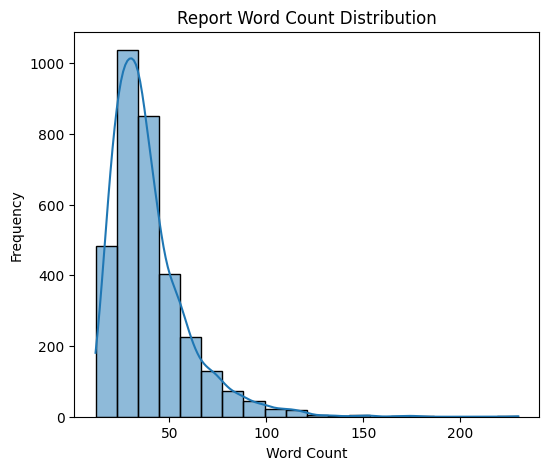

In [25]:
def run_eda(df):
    plt.figure(figsize=(6, 5))

    # Text Length Distribution
    df['text_len'] = df['report_text'].apply(lambda x: len(x.split()))
    sns.histplot(df['text_len'], bins=20, kde=True)
    plt.title("Report Word Count Distribution")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")

    plt.show()

# Load and Merge
reports = pd.read_csv(REPORTS_FILE)
projections = pd.read_csv(PROJECTIONS_FILE)

df = pd.merge(projections, reports, on='uid')
df = df[df['projection'] == 'Frontal'].reset_index(drop=True)
df.dropna(subset=['findings', 'impression', 'filename'], inplace=True)

df['report_text'] = df['findings'] + " " + df['impression']

# For demonstration, ensure binary labels exist based on 'normal' keyword
df['label'] = df['Problems'].apply(
    lambda x: 0 if 'normal' in str(x).lower() else 1
)

run_eda(df)


# Tokenizer

In [17]:
try:
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
    print("BioBERT tokenizer loaded")
except:
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    print("BioBERT unavailable, using BERT-base")

BioBERT tokenizer loaded


# Dataset Class

In [18]:
class ChestXRayMultimodalDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256, transform=None):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Image
        try:
            img = Image.open(row['image_path']).convert('RGB')
            if self.transform:
                img = self.transform(img)
        except:
            img = torch.zeros(3, 224, 224)

        # Text
        encoding = self.tokenizer(
            row['combined_text'],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'image': img,
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(row['label'], dtype=torch.long)
        }

# Image Transforms

In [19]:
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

# Train/Val/Test Split

In [20]:
train_df, temp_df = train_test_split(
    data, test_size=0.3, random_state=42, stratify=data['label']
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['label']
)

print(len(train_df), len(val_df), len(test_df))

2672 573 573


# Dataloaders

In [21]:
train_ds = ChestXRayMultimodalDataset(train_df, tokenizer, transform=image_transform)
val_ds   = ChestXRayMultimodalDataset(val_df, tokenizer, transform=image_transform)
test_ds  = ChestXRayMultimodalDataset(test_df, tokenizer, transform=image_transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)
test_loader  = DataLoader(test_ds, batch_size=16)

# Multimodal Model

In [22]:
class MultimodalModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()

        self.text_fc = nn.Linear(768, 256)
        self.classifier = nn.Linear(512 + 256, num_classes)

    def forward(self, image, text_emb):
        img_feat = self.cnn(image)
        txt_feat = self.text_fc(text_emb)
        fused = torch.cat((img_feat, txt_feat), dim=1)
        return self.classifier(fused)

# Training Loop

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from transformers import AutoModel

class MultimodalModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Image Branch
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.cnn.fc = nn.Identity()

        # Text Branch (BioBERT)
        self.transformer = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

        # Fusion and Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 768, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        img_feat = self.cnn(image)

        # Extract text features from the CLS token
        text_outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        txt_feat = text_outputs.pooler_output

        fused = torch.cat((img_feat, txt_feat), dim=1)
        return self.classifier(fused)

# --- Training Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultimodalModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) # AdamW is better for Transformers

# --- Training Loop ---
epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0
    all_preds = []
    all_labels = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in pbar:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix({'loss': loss.item()})

    # Epoch Metrics
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

    print(f"\n[Epoch {epoch+1}] Train Loss: {train_loss/len(train_loader):.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Epoch 1/5:   0%|          | 0/167 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [ ]:
def evaluate_model(model, loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            images = batch['image'].to(device)
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, ids, mask)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # 1. Performance Metrics Report
    print("\nFinal Performance Metrics:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Abnormal']))

    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Abnormal'],
                yticklabels=['Normal', 'Abnormal'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Run evaluation on test set
evaluate_model(model, test_loader, device)

In [ ]:
torch.save(
    model.state_dict(),
    "/content/drive/MyDrive/multimodal_xray_model.pth"
)